## 1. Exploratory Data Analysis And Data Pre-processing

**Exploratory Data Analysis (EDA)** and **Data Pre-processing** are the two critical steps before starting to analysis data with deep learning. Exploratory Data Analysis performs the initial analysis which allows us to achieve overall understanding on the dataset and the relationship between variables while the data preproceesing helps to clean and enhance the raw dataset to make it ready for the further steps.

Generally, EDA and data pre-processing are mutually influenced and alternated in the early stage of data analysis.

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import json

In [ ]:
# read the corespondence between id and genre
with open("drive/MyDrive/Project/data_NLP/genre_id_info.txt", "r") as f:
    content = json.loads(f.read())
    id2genre = {str(i["id"]): i["name"] for i in content}
    id2genre = dict(sorted(id2genre.items(), key=lambda x: int(x[0])))

data = pd.DataFrame(columns=["id", "genre_ids", "overview"])

for key in id2genre.keys():
    data_temp = pd.read_csv(
        f"drive/MyDrive/Project/data_NLP/{key}.csv",
        sep=",",
    )
    data = pd.concat([data, data_temp[["id", "genre_ids", "overview"]]], axis=0)

data = data.convert_dtypes()
num_data = data.shape[0]
print(f"Dataset Original Shape: {data.shape}")

Dataset Original Shape: (114000, 3)


### 1.1. Data Cleaning

Fist of all, we need to clean the raw dataset. Common methods of data preprocessing include removing duplicate records, handling missing values, processing outliers and so on.

In [ ]:
# 1. drop duplicates
data.drop_duplicates(subset="id", inplace=True, ignore_index=True)
data.drop_duplicates(subset="overview", inplace=True, ignore_index=True)

print(f"Num of Duplicates: {num_data - data.shape[0]}; Current Dataset Shape is {data.shape}", end="\n\n")
num_data = data.shape[0]

# 2. remove missing values
print(f"Missing Data:\n{data.isna().sum()}")
data.dropna(inplace=True)
data = data[~(data["genre_ids"] == "[]")]
data = data[~(data["overview"] == "No overview found.")]

print(f"Number of Missing Data: {num_data - data.shape[0]}; Current Dataset Shape: {data.shape}", end="\n\n")
num_data = data.shape[0]

# 3. discard too short overviews (which may include missing values like 'unknown overview')
print(f"Overview Description:\n{data['overview'].str.len().describe()}")
data = data[data["overview"].str.len() >= 50]
print(f"Number of Short Overviews: {num_data - data.shape[0]}; Current Dataset Shape: {data.shape}")

Num of Duplicates: 45908; Current Dataset Shape is (68092, 3)

Missing Data:
id           0
genre_ids    0
overview     1
dtype: int64
Number of Missing Data: 8; Current Dataset Shape: (68084, 3)

Overview Description:
count    68084.000000
mean       297.508357
std        186.226596
min          1.000000
25%        154.000000
50%        248.000000
75%        395.000000
max       1000.000000
Name: overview, dtype: float64
Number of Short Overviews: 715; Current Dataset Shape: (67369, 3)


Given that one movie may belong to multiple genres, we need to split the `genre_ids` attribute into different columns where a value of 1 means that the movie belongs to the genre and 0 means that it does not.


In [ ]:
for id in id2genre.keys():
    data[id] = data["genre_ids"].map(lambda x: 1 if id in x else 0)
data_original = data.copy(deep=True)
print(data.head())

       id        genre_ids                                           overview  \
0  436270     [28, 12, 14]  Nearly 5,000 years after he was bestowed with ...   
1  960704     [28, 12, 14]  The Elric brothers’ long and winding journey c...   
2  791155    [878, 12, 28]  While hanging out after school, Charlie and hi...   
3  759507     [28, 12, 53]  A man wakes in a hospital with no memory, and ...   
4  532639  [14, 12, 10751]  A wooden puppet embarks on a thrilling adventu...   

   12  14  16  18  27  28  35  ...  53  80  99  878  9648  10402  10749  \
0   1   1   0   0   0   1   0  ...   0   0   0    0     0      0      0   
1   1   1   0   0   0   1   0  ...   0   0   0    0     0      0      0   
2   1   0   0   0   0   1   0  ...   0   0   0    1     0      0      0   
3   1   0   0   0   0   1   0  ...   1   0   0    0     0      0      0   
4   1   1   0   0   0   0   0  ...   0   0   0    0     0      0      0   

   10751  10752  10770  
0      0      0      0  
1      0    

Now, we can try to "take a peek" at the data to understand more about what it represents and how to apply it.


### 1.2. Distribution of Data

Firstly we can have a look at the labels of data and their corresponding IDs.

In [ ]:
print(f"Number of Labels: {len(id2genre)}")
for k, v in id2genre.items():
    print(f"{k}: {v}", end="; ")

Number of Labels: 19
12: Adventure; 14: Fantasy; 16: Animation; 18: Drama; 27: Horror; 28: Action; 35: Comedy; 36: History; 37: Western; 53: Thriller; 80: Crime; 99: Documentary; 878: Science Fiction; 9648: Mystery; 10402: Music; 10749: Romance; 10751: Family; 10752: War; 10770: TV Movie; 

Then we want to check the number of movies in each genre to make sure that the number does not vary much, as a result of which, we don't have to worry about the imbalanced classification problem too much. The pie chart is one of the common ways to visualize the composition ratio while the tree map can demonstrate the relationship between the magnitude of the quantities more clearly.

The pie chart and tree map of the number are shown as below. And it turns out that numbers are relatively even.

In [ ]:
!pip install squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


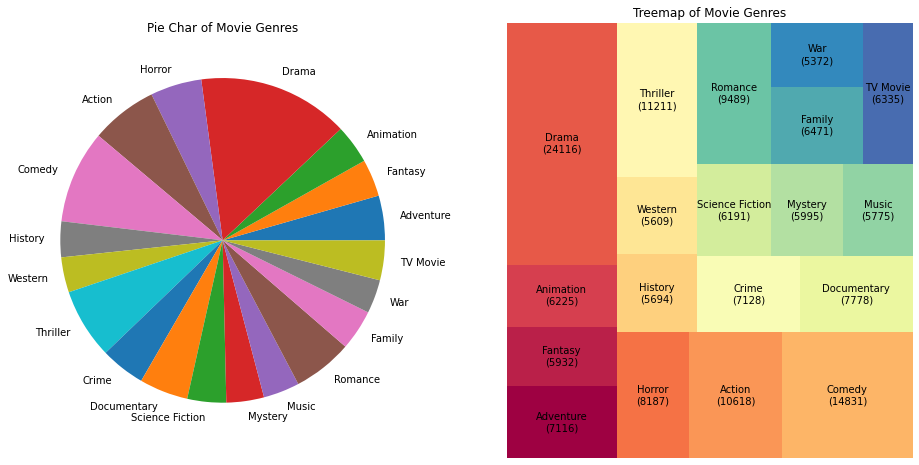

In [ ]:
import matplotlib.pyplot as plt
import squarify

data_sum = data[[str(i) for i in id2genre.keys()]].sum().reset_index(name="counts")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.pie(data_sum["counts"], labels=id2genre.values())
plt.title("Pie Char of Movie Genres")

plt.subplot(122)
squarify.plot(
    sizes=data_sum["counts"].values.tolist(),
    label=data_sum.apply(lambda x: f"{id2genre[x[0]]}\n({x[1]})", axis=1),
    color=[plt.cm.Spectral(i / float(len(id2genre))) for i in range(len(id2genre))],
)
plt.title("Treemap of Movie Genres")
plt.axis("off")
plt.show()

Obviously one movie may have multiple genres. Now let's see the number of labels per movie.

In [ ]:
data["num"] = data[id2genre.keys()].sum(axis=1)
data["num"].describe()

count    67369.000000
mean         2.376063
std          1.032481
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         11.000000
Name: num, dtype: float64

We can see that, most of movies only have at most 2 genres which means the label will be very **sparse** if we use all genres without selection. That makes it very hard for the model to learn because models will just predict all tags to 0 which has very low loss and very high accuracy (which I already tried on the multi-class multi-label classification problem). So we decide to select the 5 genres as the label to do the classification problem. Meanwhile, the size of dataset is expected to be as large as possible.

Let's first have a look at those recordings with only one genre.

In [ ]:
movie_one = data[data["num"] == 1]
for i in id2genre.keys():
    print(f"{i}: {movie_one[movie_one[i] == 1].shape[0]}")

12: 145
14: 147
16: 810
18: 860
27: 1152
28: 289
35: 892
36: 181
37: 3020
53: 287
80: 132
99: 3892
878: 365
9648: 126
10402: 1110
10749: 235
10751: 179
10752: 309
10770: 35


The most genre is "Documentary"(99) and the number is 3892 which is very small. So we need to find the combination of genres which one movie only belongs to one of them.

In [ ]:
from itertools import permutations

# sort id according to the frequency
ids = data_sum.sort_values(by="counts", ascending=False)["index"].tolist()
# generator of combination
perms = (i for i in permutations(ids, 5))

def get_genre(series, perm):
    for i, j in zip(series.index, series):
        if (i in perm) and (j == 1):
            return i

# find the maximum minimum count
count_min = 0
for perm in perms:

    data_temp = data[data[list(perm)].sum(axis=1) == 1][list(perm)]

    data_temp["genre"] = data_temp.apply(lambda x: get_genre(x, perm), axis=1)
    data_temp_count = data_temp["genre"].value_counts()
    if count_min < data_temp_count.min():
        count_min = data_temp_count.min()
        print(f"Perm: {perm}, Min Count: {count_min}")

        if 5000 - count_min <= 10:
            break

Perm: ('18', '35', '53', '28', '10749'), Min Count: 1347
Perm: ('18', '35', '53', '28', '27'), Min Count: 2331
Perm: ('18', '35', '53', '28', '99'), Min Count: 4158
Perm: ('18', '35', '28', '27', '99'), Min Count: 4994


In [ ]:
perm = ('18', '35', '28', '27', '99')
for i in perm:
    print(f"{id2genre[i]}", end=" ")
print()

data = data[data[list(perm)].sum(axis=1) == 1][list(perm) + ["overview"]]
data["genre"] = data.apply(lambda x: get_genre(x, perm), axis=1)
id2genre = {i: id2genre[i] for i in perm}

movies = None
for i in perm:
    data_temp = data[data["genre"] == i][:5000]
    if movies is None:
        movies = data_temp.copy(deep=True)
    else:
        movies = pd.concat([movies, data_temp.copy(deep=True)], ignore_index=True)
print(movies["genre"].value_counts())

Drama Comedy Action Horror Documentary 
18    5000
35    5000
28    5000
99    5000
27    4994
Name: genre, dtype: int64


We can see that the combination is "Drama", "Comedy", "Action", "Horror" and "Documentary". To balance the number of different labels, around 5000 samples of every genre are selected.

### 1.3. Word Frequency

In terms of the NLP task, we want to predict the movie genres using its overview. It's natural to check the word frequency so we can have a better understanding of the overview contents.

But we need to process these text data before that.

In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import re
import nltk

nltk.download('stopwords')

def clean_text(text):
    # 1. lowcase
    text = text.lower()

    # 2. convert short form of words
    for i, j in [("won't", "will not"), ("'t", " not"), ("'re", " are"), ("'s", " is"), \
        ("'d", " would"), ("'ll", " will"), ("'ve", " have"), ("'m", " am")]:
        text = re.sub(i, j, text)
    
    # 3. remove all punctuations
    text = re.sub("[^a-zA-Z]", " ", text)

    return text

# 4. remove STOPWORDS
def sw(text):    
    text = " ".join([word for word in text.split() if word not in nltk.corpus.stopwords.words('english')])
    return text

data["text"] = data["overview"].apply(lambda x: clean_text(x))
data["text_sw"] = data["text"].apply(lambda x: sw(x))
print(f"Original Text: {data['overview'][0]}\n\nProcessed Text: {data['text'][0]}\n\nProcessed Text (Stopwords): {data['text_sw'][0]}")

data[list(perm) + ["text"]].to_csv("drive/MyDrive/Project/data_NLP/data.csv", sep=",", index=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Original Text: Nearly 5,000 years after he was bestowed with the almighty powers of the Egyptian gods—and imprisoned just as quickly—Black Adam is freed from his earthly tomb, ready to unleash his unique form of justice on the modern world.

Processed Text: nearly       years after he was bestowed with the almighty powers of the egyptian gods and imprisoned just as quickly black adam is freed from his earthly tomb  ready to unleash his unique form of justice on the modern world 

Processed Text (Stopwords): nearly years bestowed almighty powers egyptian gods imprisoned quickly black adam freed earthly tomb ready unleash unique form justice modern world


 The steps of proceesing include lowcase, removal punctuations and convertion short forms removal stopwords so we can focus on those more important words if we remove them from the text. 

 Have a look at the stopwords.

In [ ]:
print(f"Common Words: {', '.join(nltk.corpus.stopwords.words('english'))}")

Common Words: i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn'

In this section, we find the 80 most frequent words of all collected overviews and then delete the common words in it because they may not make much sense. The bar plot of word frequency is shown as below.


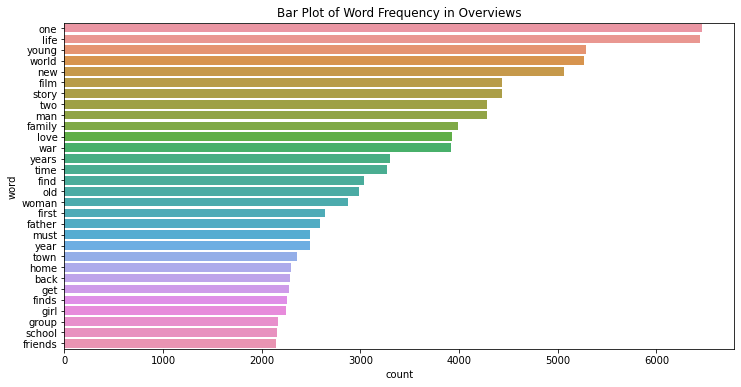

In [ ]:
import nltk
import seaborn as sns

content = " ".join(data["text_sw"])
fdist = nltk.FreqDist(content.split())
words_df = pd.DataFrame({"word": list(fdist.keys()), "count": list(fdist.values())})

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=words_df.nlargest(columns="count", n=30), x="count", y="word")
ax.set(title="Bar Plot of Word Frequency in Overviews")
plt.show()

As we can see in the plot, the most frequent words consist of the words relating to the main characters and the theme of movies. Specifically, **one**, **two** and other quantifiers are used to indicate the number of main characters generally; **young**, **man** and **girl** are used to indicate their characteristics (gender, age and etc.) while **love**, **world** and **war** are in connection with the movie themes. According to the definition, "film genres are usually delineated by '_conventions_, _iconography_, _settings_, _narratives_, _characters_ and _actors_.'" Given that the overview contains these factors, we believe that it’s viable to predict the movie genre utilizing its plot overview.

A short example is shown as below which consists of "war", "one" and "man" as mentioned before:


In [ ]:
print(data["overview"][69])

As a collection of history's worst tyrants and criminal masterminds gather to plot a war to wipe out millions, one man must race against time to stop them.


### 1.4. Word Cloud

In this section, we want to draw the word cloud graphs for every movie genre and see whether the most frequent words can reflect the characteristics of different genres.


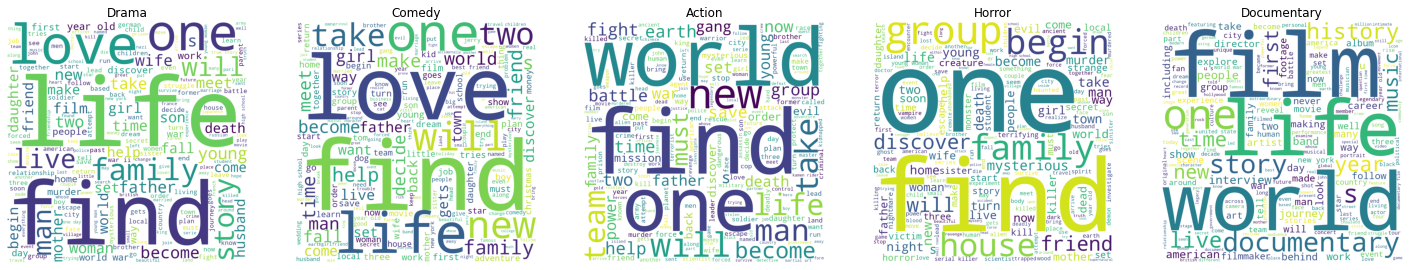

In [ ]:
from wordcloud import WordCloud

plt.figure(figsize=(25, 5))

for i, (id, value) in enumerate(id2genre.items()):

    plt.subplot(1, 5, i + 1)
    content = "".join(data[data[id] == 1]["overview"]).lower()
    word_cloud = WordCloud(width=1000, height=1000, background_color="white").generate(
        content
    )
    plt.imshow(word_cloud)
    plt.title(value)
    plt.axis("off")

plt.show()

Other than the common words like "find" and "life", the most frequent words do have to do with genres.

For example, with regard to the "Action" movies, **team** and **time** are two of the most frequent words while 
the protagonists form a team to complete the task in a limited amount of time in this kind of movies, like: James Bond series. In addition, **house** is one of common scenes in the "Horror" movies like: The Shining. As to the "Documentary" ones, it's easy to understand that **history** is the common word because the content of this kind of movies is usually related to the history event.

All in all, it looks reasonable to use the overview to predict the genre of movies.


### 1.5. Correlation Heatmap

In this section, we are intended to check the correlation between different genres to make sure that genres are not too similar to effect the classifcation performance.

First of all, we check the number of frequency of simultaneous appearance of different genres so we can have a look at the relationship between the attributes roughly but visually.

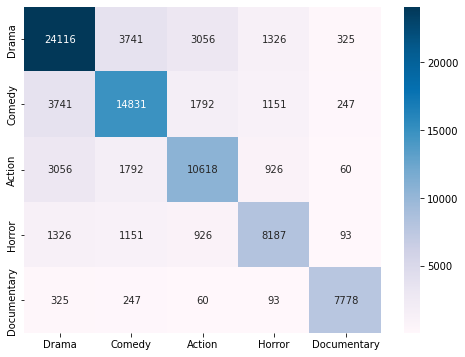

In [ ]:
import seaborn as sns

data_genres = data_original[id2genre.keys()]

genre_count = []
for i in id2genre.keys():
    temp_count = []
    for j in id2genre.keys():
        temp_count.append(
            data_genres[(data_genres[i] == 1) & (data_genres[j] == 1)].shape[0]
        )
    genre_count.append(temp_count)

plt.figure(figsize=(8, 6))

sns.heatmap(
    pd.DataFrame(genre_count),
    xticklabels=id2genre.values(),
    yticklabels=id2genre.values(),
    annot=True,
    cmap="PuBu",
    fmt="d",
)
plt.show()

As we can see in the heatmap, the value in the *i*-th row, *j*-th col indicates the number of movies belonging to both the *i*-th and *j*-th genres.

We can get some interesting insights from the heatmap, for example, there are 3741 movies that belongs to "Drama" and "Comedy" while there are 24116 "Drama" moives and 14831 "Comedy" moives. That's easy to understand: Drama movies tend to encourage a broader range of moods which contains humor.  As a result, we need to further determine whether the different genres will be too similar in terms of statistical significance.

Because these genre attributions are categorical (binary) variable instead of numeric variables, the common Pearson correlation coefficient doesn't make much sense which is used to reflect the linear correlation between variables. And we choose to use the Cramér's V here to measure the association between nominal variables.

Max Value: 0.23819978477992368, Min Value: 0.04520099671924724


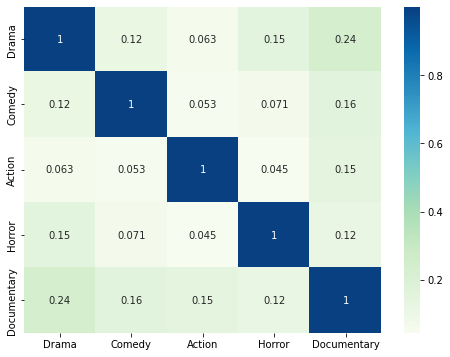

In [ ]:
from scipy.stats import chi2_contingency
import numpy as np


def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


data_corr = []
max_corr, min_corr = -np.inf, np.inf

for i in id2genre.keys():
    temp = []
    for j in id2genre.keys():
        value = cramers_v(data_genres[i], data_genres[j])
        temp.append(value)
        if i != j:
            max_corr = max(max_corr, value)
            min_corr = min(min_corr, value)
    data_corr.append(temp)



print(f"Max Value: {max_corr}, Min Value: {min_corr}")

plt.figure(figsize=(8, 6))
sns.heatmap(
    pd.DataFrame(data_corr),
    xticklabels=id2genre.values(),
    yticklabels=id2genre.values(),
    annot=True,
    cmap="GnBu",
)
plt.show()

As we can see from the result, the maximum value is around 0.24 which is related to the Drama and Documentary. It is small so we can think all these genres are not independent from each other.